In [27]:
# xp run --include-dirty --name={datetime}-{task} configs/xprun/train.ron -t
# task=bigfish,bossfight,cherry_pick,count,floor_is_lava,leaper,minefield,move_to_origin,multi_armed_bandit,multisnake_1snakes11len,multisnake_2snakes11len,not_hotdog,pick_matching_balls,plunder,rock_paper_scissors,starpilot,xor]
# num_envs=128,256
# lr=0.01,0.003,0.001,0.0003
# dmodel=16,32,64
# nlayer=2
# gamma=0.99
# ent_coef=0.3,0.1,0.03,0.01,0.003
# anneal_ent=true,false
# bs=256,512,1024 --copies=1 --
# --config=configs/allsweep/{task}.ron total_timesteps=1000000 track=true rollout.steps=16 rollout.processes=8  rollout.num_envs={num_envs} optim.lr={lr} net.d_model={dmodel} net.n_layer={nlayer} ppo.gamma={gamma} ppo.ent_coef={ent_coef} optim.bs={bs} ppo.anneal_entropy={anneal_ent}
import wandb
import csv
import json

def nested_lookup(key, nested_dict):
    for k in key:
        nested_dict = nested_dict[k]
    return nested_dict


def download_data(run_prefix: str, target_path: str, columns: dict):
    api = wandb.Api(timeout=100)
    runs = api.runs(
        "entity-neural-network/enn-ppo",
        filters={"config.name": {"$regex": f"{run_prefix}.*"}}
    )
    with open(target_path, "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(list(columns.keys()) + ["episodic_reward.mean", "episodic_reward.count", "reward.mean", "charts/SPS"])
        for run in runs:
            if run.name.startswith(run_prefix) and run:
                try:
                    summary = run.summary
                    if "episodic_reward.mean" not in summary:
                        print(f"{run.name} not finished")
                        continue
                    config = json.loads(run.json_config)
                    row = [
                        nested_lookup(path, config)
                        for path in columns.values()
                    ] + [
                        summary["episodic_reward.mean"],
                        summary["episodic_reward.count"],
                        summary["reward.mean"],
                        summary["charts/SPS"],
                    ]
                    writer.writerow(row)
                except Exception as e:
                    print(run.config)
                    print(run.summary.keys())
                    raise e

download_data(
    "220511-055353",
    "sweep2.csv",
    columns={
        "task": ["env", "value", "id"],
        "kwargs": ["env", "value", "kwargs"],
        "num_envs": ["rollout", "value", "num_envs"],
        "lr": ["optim", "value", "lr"],
        "dmodel": ["net", "value", "d_model"],
        "nlayer": ["net", "value", "n_layer"],
        "gamma": ["ppo", "value", "gamma"],
        "ent_coef": ["ppo", "value", "ent_coef"],
        "bs": ["optim", "value", "bs"],
        "anneal_ent": ["ppo", "value", "anneal_entropy"],
    },
)

220511-055353-bossfight-num_envs=256-ent_coef=0.003-dmodel=64-anneal_ent=true-bs=256-lr=0.003 not finished
220511-055353-not_hotdog-num_envs=256-ent_coef=0.003-dmodel=32-anneal_ent=false-bs=512-lr=0.001 not finished
220511-055353-floor_is_lava-num_envs=256-ent_coef=0.003-dmodel=32-anneal_ent=false-bs=512-lr=0.001 not finished
220511-055353-multisnake_1snakes11len-num_envs=256-ent_coef=0.01-dmodel=16-anneal_ent=false-bs=1024-lr=0.0003 not finished
220511-055353-multisnake_1snakes11len-num_envs=256-ent_coef=0.01-dmodel=16-anneal_ent=false-bs=1024-lr=0.001 not finished
220511-055353-multisnake_1snakes11len-num_envs=256-ent_coef=0.01-dmodel=16-anneal_ent=false-bs=1024-lr=0.003 not finished
220511-055353-leaper-num_envs=256-ent_coef=0.03-dmodel=32-anneal_ent=false-bs=256-lr=0.01 not finished
220511-055353-not_hotdog-num_envs=128-ent_coef=0.01-dmodel=64-anneal_ent=true-bs=512-lr=0.01 not finished
220511-055353-leaper-num_envs=128-ent_coef=0.01-dmodel=32-anneal_ent=false-bs=512-lr=0.003 not f

In [38]:
# Read data
import matplotlib.pyplot as plt
import pandas
pandas.set_option('display.expand_frame_repr', False)
df = pandas.read_csv("sweep2.csv")
# Get count of each task
task_counts = df[["task", "kwargs"]].value_counts()

# Add new column "normrew" initialized to 0
df["normrew"] = 0
# Add "normalized_reward" column which is the reward normalized to the min/max of the task
for task, kwargs in task_counts.index:
    dft = df[(df["task"] == task) & (df["kwargs"] == kwargs)]
    df.loc[(df["task"] == task) & (df["kwargs"] == kwargs), "normrew"] =  (dft["reward.mean"] - dft["reward.mean"].min()) / (dft["reward.mean"].max() - dft["reward.mean"].min())

# Filter out all tasks that don't start with "Procgen:"
# df = df[df["task"].str.startswith("Procgen:")]

# Aggregate over all tasks
#df_agg = df.groupby(["num_envs", "lr", "dmodel", "nlayer", "gamma", "ent_coef", "bs", "anneal_ent"]).agg({"normrew": "mean"}).reset_index()
df_agg = df.groupby(["num_envs", "lr", "dmodel", "ent_coef", "bs", "anneal_ent"]).agg({"normrew": "mean", "charts/SPS": "mean"}).reset_index()

# Print top 30
top = df_agg.sort_values(by="normrew", ascending=False)
print(top.head(20))

     num_envs      lr  dmodel  ent_coef    bs  anneal_ent   normrew   charts/SPS
143       128  0.0010      32     0.100  1024        True  0.789319  3928.941176
510       256  0.0010      64     0.003   256       False  0.776066  2302.882353
79        128  0.0003      64     0.100   256        True  0.773127  2047.647059
77        128  0.0003      64     0.030  1024        True  0.772104  3978.937500
189       128  0.0030      16     0.010   512        True  0.766997  3057.411765
136       128  0.0010      32     0.030  1024       False  0.765822  3892.588235
195       128  0.0030      16     0.030   512        True  0.765028  3021.117647
574       256  0.0030      32     0.003  1024       False  0.764899  5078.470588
121       128  0.0010      32     0.003   256        True  0.762689  2069.235294
137       128  0.0010      32     0.030  1024        True  0.762232  3930.411765
129       128  0.0010      32     0.010   512        True  0.759918  3033.235294
497       256  0.0010      3

In [39]:
# Print full scores for top 1 config
top_config = top.iloc[0]
df[(df["num_envs"] == top_config["num_envs"]) & (df["lr"] == top_config["lr"]) & (df["dmodel"] == top_config["dmodel"]) & (df["ent_coef"] == top_config["ent_coef"]) & (df["bs"] == top_config["bs"]) & (df["anneal_ent"] == top_config["anneal_ent"])]

,task,kwargs,num_envs,lr,dmodel,nlayer,gamma,ent_coef,bs,anneal_ent,episodic_reward.mean,episodic_reward.count,reward.mean,charts/SPS,normrew
10196,Xor,{},128,0.001,32,2,0.99,0.1,1024,True,1.000000,2048,1.000000,5662,1.000000
10220,Procgen:StarPilot,{},128,0.001,32,2,0.99,0.1,1024,True,3.923077,26,0.052246,1970,1.000000
10243,RockPaperScissors,{},128,0.001,32,2,0.99,0.1,1024,True,1.122070,2048,1.122070,5308,0.928116
10267,Procgen:Plunder,{},128,0.001,32,2,0.99,0.1,1024,True,2.307692,13,0.017090,2108,0.795455
10291,PickMatchingBalls,"{""max_balls"": 32, ""one_hot"": true, ""randomize""...",128,0.001,32,2,0.99,0.1,1024,True,0.761697,430,0.159927,3727,0.641271
10315,NotHotdog,{},128,0.001,32,2,0.99,0.1,1024,True,1.000000,2048,1.000000,4828,1.000000
10339,MultiSnake,"{""num_snakes"": 2, ""max_snake_length"": 11}",128,0.001,32,2,0.99,0.1,1024,True,0.527941,34,0.009546,3550,0.794297
10363,MultiSnake,"{""num_snakes"": 1, ""max_snake_length"": 11}",128,0.001,32,2,0.99,0.1,1024,True,0.975758,33,0.013916,3688,0.922330
10387,MultiArmedBandit,{},128,0.001,32,2,0.99,0.1,1024,True,1.000000,128,0.031250,6996,1.000000
10411,MoveToOrigin,{},128,0.001,32,2,0.99,0.1,1024,True,0.981635,128,0.011138,5721,0.547030


In [41]:
df_agg

,num_envs,lr,dmodel,ent_coef,bs,anneal_ent,normrew,charts/SPS
0,128,0.0003,16,0.003,256,False,0.670780,2095.117647
1,128,0.0003,16,0.003,256,True,0.646545,2096.117647
2,128,0.0003,16,0.003,512,False,0.577515,3025.294118
3,128,0.0003,16,0.003,512,True,0.566205,3032.705882
4,128,0.0003,16,0.003,1024,False,0.576747,3956.352941
...,...,...,...,...,...,...,...,...
715,256,0.0100,64,0.300,256,True,0.578158,2377.823529
716,256,0.0100,64,0.300,512,False,0.519471,3673.705882
717,256,0.0100,64,0.300,512,True,0.658852,3653.176471
718,256,0.0100,64,0.300,1024,False,0.581065,5092.117647


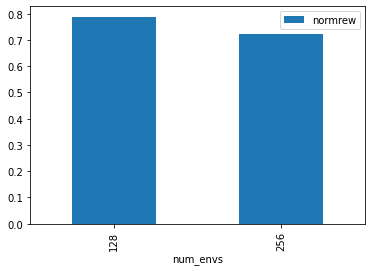

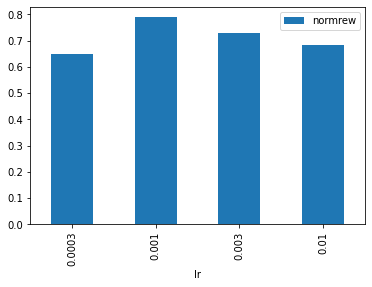

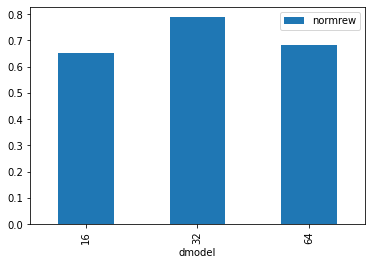

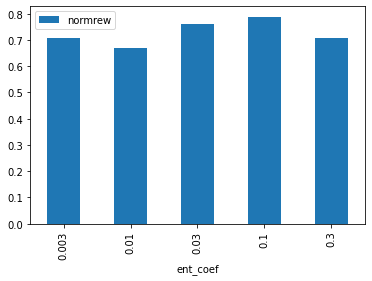

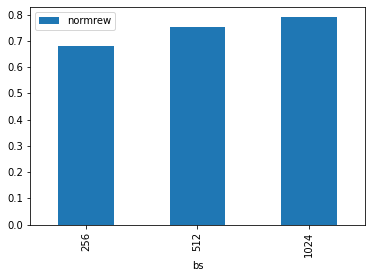

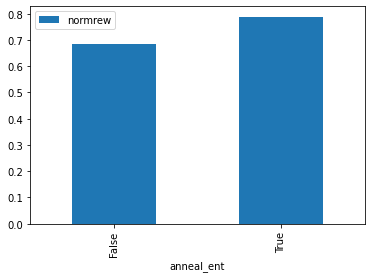

In [46]:
# Plot performance against each hyperparameter, with all other hyperparameters fixed to their top value
all_params = ["num_envs", "lr", "dmodel", "ent_coef", "bs", "anneal_ent"]
for param in all_params:
    # dataframe with only the top value of all other hyperparameters
    df_top = df_agg.copy()
    for other_param in all_params:
        if other_param != param:
            df_top = df_top[df_top[other_param] == top_config[other_param]]
    # Plot
    df_top.plot(x=param, y="normrew", kind="bar")
    # fig, ax = plt.subplots(figsize=(8,6))
    # ax.bar(df_top[param], df_top["normrew"], label=param)
    # ax.set_xlabel(param)
    # ax.set_ylabel("Normalized reward")
    # ax.legend()

In [ ]:
for param in ["num_envs", "dmodel", "nlayer", "bs", "ent_coef"]:
    df_envs = df_agg.groupby([param]).agg({"normrew": "max"}).reset_index()
    df_envs.plot(x=param, y="normrew", kind="bar")

for dmodel in [8, 32, 128]:
    for ent_coef in [0.03, 0.1, 0.3]:
        #for nlayer in [1, 2, 4]:
        #for bs in [512, 4096]:
        # Filter by dmodel, nlayer, num_envs
        _df = df_agg[df_agg["dmodel"] == dmodel]
        _df = _df[_df["ent_coef"] == ent_coef]
        #_df = _df[_df["nlayer"] == nlayer]
        # Plot reward.mean against learning rate for 32 and 128 environments
        fig, ax = plt.subplots(figsize=(8,6))
        #for num_envs in [32, 128]:
        for bs in [512, 2048]:
            __df = _df[_df["bs"] == bs]
            ax.plot(__df["lr"], __df["normrew"], label=f"{bs}")
        ax.set_xscale("log")
        ax.title.set_text(f"dmodel={dmodel}, ent_coef={ent_coef}")
        ax.legend()